In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import time
INPUT_DIR = '/Users/fuchunhsieh/Desktop/Fall_2023/Comp_Sci_539/Project/free-spoken-digit-dataset-master/recordings'
OUTPUT_DIR = '/Users/fuchunhsieh/Desktop/Fall_2023/Comp_Sci_539/Project'

# list all the files and directories within a specified directory
# parent_list = os.listdir(INPUT_DIR)
# print(len(parent_list)) # 6 speakers, 10 digits, 50 recordings for each digit
# for i in range(10):
#     print(parent_list[i])

# Convert audio files to image files

In [2]:
# only need to do once, convert audio file to images
t_process_0 = time.process_time()
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = np.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate
if not os.path.exists(os.path.join(OUTPUT_DIR, 'audio-images')):
    os.mkdir(os.path.join(OUTPUT_DIR, 'audio-images'))
    for filename in os.listdir(INPUT_DIR):
        if "wav" in filename:
            file_path = os.path.join(INPUT_DIR, filename)
            file_stem = Path(file_path).stem
            target_dir = f'class_{file_stem[0]}'
            dist_dir = os.path.join(OUTPUT_DIR, 'audio-images', target_dir)
            file_dist_path = os.path.join(dist_dir, file_stem)
            if not os.path.exists(dist_dir):
                os.makedirs(dist_dir)
            if not os.path.exists(file_dist_path + '.png'):
                file_stem = Path(file_path).stem
                sound_info, frame_rate = get_wav_info(file_path)
                tf.stft(frame_step=frame_rate)
                pylab.savefig(f'{file_dist_path}.png')
                pylab.close()
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images'))
# print("Classes: \n")
# for i in range(10):
#     print(path_list[i])

# path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images/class_1'))
# print("\nA few example files: \n")
# for i in range(10):
#     print(path_list[i])
t_process_1 = time.process_time()
# print(t_process_1-t_process_0)

image process time 989.6 \
average time per sample to process = 0.33 (s)

# Load and Process Data


In [38]:
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
BATCH_SIZE = 32
N_CHANNELS = 1
N_CLASSES = 10

directory = os.path.join(OUTPUT_DIR, 'audio-images')
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    batch_size = BATCH_SIZE,
    validation_split = 0.3,
    directory=directory,
    shuffle = True,
    color_mode = 'grayscale',
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    subset = "training",
    seed = 42
)

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    batch_size = BATCH_SIZE,
    validation_split = 0.3,
    directory=directory,
    shuffle = True,
    color_mode = 'grayscale',
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    subset = "validation",
    seed = 42
)

def split_dataset(dataset, split_fraction=0.5):
  dataset_size = len(dataset)
  split_size = int(dataset_size * split_fraction)
  dataset = dataset.shuffle(buffer_size=dataset_size)
  return dataset.take(split_size), dataset.skip(split_size)

test_dataset, valid_dataset = split_dataset(valid_dataset, split_fraction=0.5)
print('validation dataset is further split into 50/50 test/valid dataset', '\n')
print('batch size:', BATCH_SIZE)
print('train_dataset batch numbers:', len(train_dataset))
print('valid_dataset batch numbers:', len(valid_dataset))
print('test_dataset batch numbers:', len(test_dataset))

Found 3000 files belonging to 10 classes.
Using 2100 files for training.
Found 3000 files belonging to 10 classes.
Using 900 files for validation.
validation dataset is further split into 50/50 test/valid dataset 

batch size: 32
train_dataset batch numbers: 66
valid_dataset batch numbers: 15
test_dataset batch numbers: 14


# CNN Model

In [39]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 batch_normalization_14 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Ba  (None, 16, 16, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)        18496     
                                                      

In [40]:
epochs = 15
early_stopping = EarlyStopping(monitor='val_loss', patience=2, min_delta=0.01, mode='min', verbose=1)
history = model.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, callbacks=[early_stopping])

Epoch 1/15
66/66 [==============================] - 3s 40ms/step - loss: 1.5489 - accuracy: 0.5257 - val_loss: 7.1324 - val_accuracy: 0.1549
Epoch 2/15
66/66 [==============================] - 3s 40ms/step - loss: 0.4458 - accuracy: 0.8629 - val_loss: 6.4247 - val_accuracy: 0.1292
Epoch 3/15
66/66 [==============================] - 3s 41ms/step - loss: 0.2591 - accuracy: 0.9214 - val_loss: 3.6412 - val_accuracy: 0.2810
Epoch 4/15
66/66 [==============================] - 3s 42ms/step - loss: 0.1947 - accuracy: 0.9490 - val_loss: 1.0744 - val_accuracy: 0.7810
Epoch 5/15
66/66 [==============================] - 3s 42ms/step - loss: 0.1413 - accuracy: 0.9619 - val_loss: 0.3380 - val_accuracy: 0.9021
Epoch 6/15
66/66 [==============================] - 3s 41ms/step - loss: 0.0944 - accuracy: 0.9767 - val_loss: 0.5955 - val_accuracy: 0.8146
Epoch 7/15
66/66 [==============================] - 3s 42ms/step - loss: 0.0760 - accuracy: 0.9838 - val_loss: 0.1669 - val_accuracy: 0.9542
Epoch 8/15
66

In [6]:
# # Plot the loss curves for training and validation.
# history_dict = history.history
# loss_values = history_dict['loss']
# val_loss_values = history_dict['val_loss']
# epochs = range(1, len(loss_values)+1)

# plt.figure(figsize=(8,6))
# plt.plot(epochs, loss_values, 'bo', label='Training loss')
# plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [7]:
# # Plot the accuracy curves for training and validation.
# acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_accuracy']
# epochs = range(1, len(acc_values)+1)

# plt.figure(figsize=(8,6))
# plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
# plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [8]:
# # Compute the final loss and accuracy
# final_loss, final_acc = model.evaluate(valid_dataset, verbose=0)
# print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

In [9]:
# print(model.summary())

In [41]:
import time

# Start the timer.
t0 = time.process_time()


final_loss, final_acc = model.evaluate(test_dataset, verbose=0)

# Stop the timer.0
t1 = time.process_time()

# print((t1-t0), len(valid_dataset), 'batches')
avg_time = (t1 - t0) / len(valid_dataset) / 30
print("Average time per sample: ", avg_time)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

# penalty = ... # whatever, we'll find this out later.
# adjusted_acc = final_acc / (1 + penalty * avg_time)

# print("Time adjusted final accuracy: {1:.6f}".format(adjusted_acc))

Average time per sample:  0.012139908888888915
Final loss: 0.206272, final accuracy: 0.942857


5.33727300000001 15 batches
Average time per batch:  0.3558182000000007
Final loss: 0.291075, final accuracy: 0.900000 \
5.325380999999993 15 batches
Average time per batch:  0.35502539999999955
Final loss: 0.170305, final accuracy: 0.955357 \
5.40189300000003 15 batches
Average time per batch:  0.36012620000000195
Final loss: 0.292220, final accuracy: 0.928571 \
5.467108999999994 15 batches
Average time per batch:  0.3644739333333329
Final loss: 0.384134, final accuracy: 0.897321

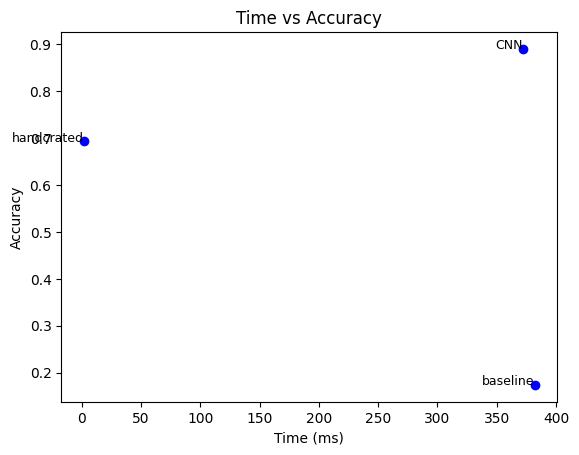

In [42]:
import matplotlib.pyplot as plt
import math
times = [0.382, 0.372, 0.001835]
for i in range(len(times)):
    times[i] *= 1000
accuracies = [0.1738, 0.89, 0.693]
labels = ['baseline', 'CNN', 'handcrated']

plt.scatter(times, accuracies, color='blue')
for i in range(len(times)):
    plt.text(times[i], accuracies[i], labels[i], fontsize=9, ha='right')

plt.title('Time vs Accuracy')
plt.xlabel('Time (ms)')
plt.ylabel('Accuracy')

plt.show()

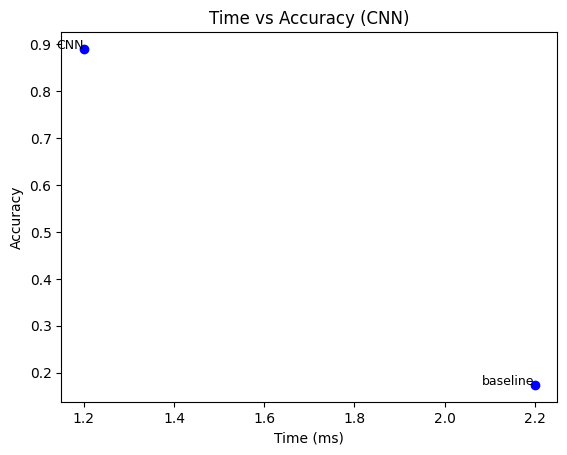

In [45]:
times = [2.2, 1.2]
accuracies = [0.1738, 0.89]
labels = ['baseline', 'CNN']

plt.scatter(times, accuracies, color='blue')
for i in range(len(times)):
    plt.text(times[i], accuracies[i], labels[i], fontsize=9, ha='right')

plt.title('Time vs Accuracy (CNN)')
plt.xlabel('Time (ms)')
plt.ylabel('Accuracy')

plt.show()

In [1]:
parameters = [8487498, 622602, 243000]
accuracies = [0.1738, 0.93, 0.693]
labels = ['baseline', 'CNN', 'handcrated']
# Creating the scatter plot
plt.scatter(parameters, accuracies, color='blue')
for i in range(len(parameters)):
    plt.text(parameters[i], accuracies[i], labels[i], fontsize=9, ha='right')
# Adding title and labels
plt.title('Parameters vs Accuracy')
plt.xlabel('Number of Parameters (Model)')
plt.ylabel('Accuracy')
# Show the plot
plt.show()

NameError: name 'plt' is not defined